In [21]:
import os
from glob import glob
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon
from itertools import combinations

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Multiple seeds experiment

In [44]:
# Load scores from multiple runs with multiple seeds
dirpaths = glob('../experiments/data/outputs/seeds/mvn_experiment/seed_*')
scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[]}
for dirpath in dirpaths:
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['KRR-baseline'].append(foo['baseline'])
        scores['KRR-after'].append(foo['after'])
        scores['KRR-before'].append(foo['before'])

with open('../experiments/data/outputs/seeds/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    scores['RF-baseline'] = foo['baseline']
    scores['RF-after'] = foo['after']

scores_df = pd.DataFrame(scores)

In [45]:
scores_df.aggregate(['mean', 'median', 'std'])

,KRR-baseline,KRR-after,KRR-before,RF-baseline,RF-after
mean,0.608359,0.556671,0.562600,0.660878,0.647485
median,0.558371,0.519625,0.517150,0.643825,0.635362
std,0.204738,0.147606,0.159919,0.091793,0.088320


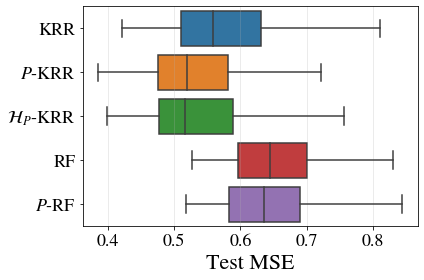

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(alpha=0.3)
sns.boxplot(data=scores_df, orient='h', showfliers=False, ax=ax)

ax.set_xlabel("Test MSE", fontsize=22)
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P-$RF'])
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

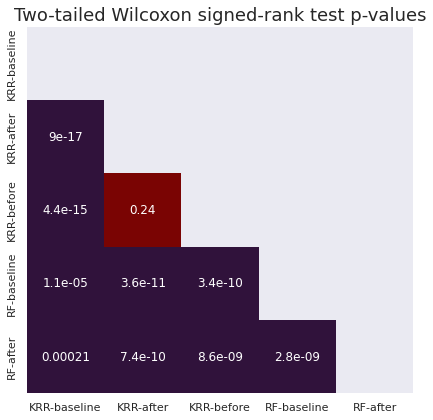

In [106]:
def paired_wilcoxon(df):
    cols = df.columns
    W_values = np.zeros((len(cols), len(cols)))
    p_values = np.zeros((len(cols), len(cols)))
    for i, j in combinations(range(len(cols)), 2):
        W, p = wilcoxon(x=df[cols[i]].values,
                        y=df[cols[j]].values)
        W_values[i, j] = W
        p_values[i, j] = p
    W_values =  W_values + W_values.T - np.eye(len(cols))
    p_values = p_values + p_values.T - np.eye(len(cols))
    W_df = pd.DataFrame(data=W_values, columns=cols, index=cols)
    p_df = pd.DataFrame(data=p_values, columns=cols, index=cols)
    return W_df, p_df

W_df, p_df_mse = paired_wilcoxon(scores_df)


sns.set(font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = np.zeros_like(p_df_mse, dtype=bool)
mask[np.triu_indices_from(mask)] = True
p_df_mse[mask] = np.nan
sns.heatmap(p_df_mse, cmap="turbo", annot=True, cbar=False, ax=ax) 
ax.set_title("Two-tailed Wilcoxon signed-rank test p-values", fontsize=18)
plt.tight_layout()
plt.show()

### n_train experiment

In [29]:
dirpaths = glob('../experiments/data/outputs/n_train/mvn_experiment/*')
scores = {'baseline':[], 'after':[], 'before':[], 'ntrain': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, ntrain = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['baseline'].append(foo['baseline'])
        scores['after'].append(foo['after'])
        scores['before'].append(foo['before'])
        scores['ntrain'].append(ntrain)
        scores['seed'].append(seed)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])

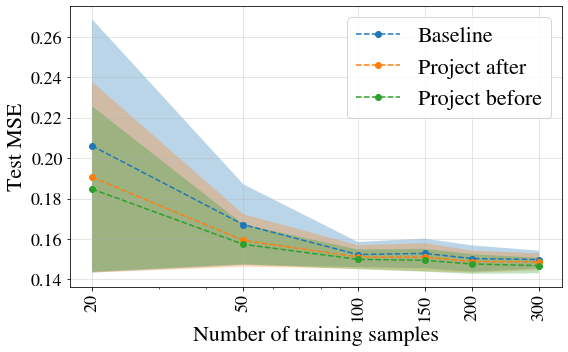

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 22
labelsize = 18

ntrain = scores_df.index.values.astype(int)

baseline_mean = scores_df.baseline['mean']
baseline_ub = baseline_mean + scores_df.baseline['std']
baseline_lb = baseline_mean - scores_df.baseline['std']

after_mean = scores_df.after['mean']
after_ub = after_mean + scores_df.after['std']
after_lb = after_mean - scores_df.after['std']

before_mean = scores_df.before['mean']
before_ub = before_mean + scores_df.before['std']
before_lb = before_mean - scores_df.before['std']


ax.plot(ntrain, baseline_mean, ls='--', marker='o', label='Baseline')
ax.fill_between(ntrain, baseline_lb, baseline_ub, alpha=0.3)

ax.plot(ntrain, after_mean, ls='--', marker='o', label='Project after')
ax.fill_between(ntrain, after_lb, after_ub, alpha=0.3)

ax.plot(ntrain, before_mean, ls='--', marker='o', label='Project before')
ax.fill_between(ntrain, before_lb, before_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()